# Assignment 4 - Blackjack

In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from tensorflow import keras

Load the environment

In [2]:
env = gym.make("Blackjack-v1", sab=False, render_mode="rgb_array")

(14, 10, 0)
Observation shape: (3,)


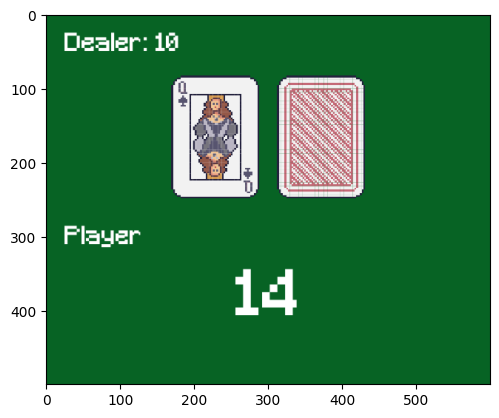

In [3]:
from matplotlib import pyplot as plt


observation, info = env.reset()
print(observation)
print("Observation shape:", np.array(observation).shape)

screen = env.render()
plt.imshow(screen)

Define a policy

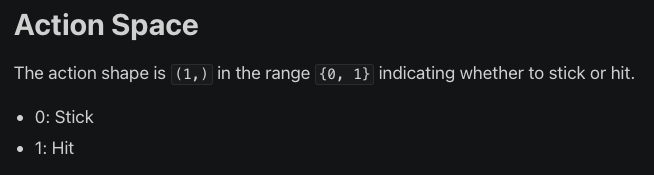

In [4]:
def define_policy(observation):
    return 0 if observation[0] >= 17 else 1

Simple policy impl:

In [5]:
num_episodes = 1000
wins = 0

for i in range(num_episodes):
    observation, info = env.reset()
    while True:
        action = define_policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            wins += 1 if reward > 0 else 0
            break

print(f"Win rate :{wins/num_episodes * 100:.2f}%")

Win rate :40.10%


DEEP Q-Learning

In [6]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
import random
import matplotlib.pyplot as plt

In [7]:
class BlackjackAgent:
    def __init__(self, state_size, action_size, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=2000, batch_size=32):
        self.state_size = state_size
        self.action_size = action_size
        self.discount_factor = discount_factor  
        self.epsilon = epsilon  #Exploration rate
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.learning_rate = learning_rate
        self.batch_size = batch_size

        self.memory = deque(maxlen=memory_size) #A fixed number of experience replays (when over, the oldest is removed)

        self.q_network = self.build_model()

    def build_model(self):
        """Q-value network that is replacing the Q-table"""
        model = keras.Sequential()
        model.add(keras.layers.Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(keras.layers.Dense(32, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randrange(self.action_size)  # Explore
        state = np.expand_dims(state, axis=0)
        q_values = self.q_network.predict(state, verbose=0)
        return np.argmax(q_values[0])  # Exploit
    
    def train_from_replay(self):
        """The function uses experience replay to train the Q-network, stabilizing the learning process by using a random sample of past experiences. The target represents the expected return for a given state-action pair, helping the network to learn the optimal policy."""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([state for state, _, _, _, _ in minibatch])
        next_states = np.array([next_state for _, _, _, next_state, _ in minibatch])
        targets = self.q_network.predict(states, verbose=0)
        next_targets = self.q_network.predict(next_states, verbose=0)

        for i, (state, action, reward, next_state, done) in enumerate(minibatch):
            target = reward if done else reward + self.discount_factor * np.max(next_targets[i])
            targets[i][action] = target

        self.q_network.fit(states, targets, epochs=1, verbose=0)
        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

In [8]:
def train_agent(episodes=1000, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=2000, batch_size=32):
    env = gym.make('Blackjack-v1', sab=True)
    state_size = 3  # (player_sum, dealer_card, usable_ace)
    action_size = env.action_space.n  # Two actions: stick (0) or hit (1)
    agent = BlackjackAgent(state_size, action_size, learning_rate, discount_factor, epsilon, epsilon_decay, min_epsilon, memory_size, batch_size)
    win_count = 0

    win_rates = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = np.array(state, dtype=np.float32)
        done = False
        total_reward = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = np.array(next_state, dtype=np.float32)

            if terminated or truncated:
                done = True

            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward

        if total_reward > 0:
            win_count += 1

        if len(agent.memory) > batch_size:
            agent.train_from_replay()

        #print win rate stats every 50 games    
        if (episode + 1) % 50 == 0:
            win_rate = win_count / (episode + 1)
            win_rates.append(win_rate)
            print(f"Episode {episode + 1}, Win Rate: {win_rate:.2f}, Epsilon: {agent.epsilon:.2f}")

    return agent, win_rates

In [9]:
def visualize_dqn_results(agent, win_rates):
    # Plot win rate over episodes
    plt.figure(figsize=(12, 5))
    plt.plot(range(100, len(win_rates) * 100 + 1, 100), win_rates, label='Win Rate')
    plt.xlabel('Episodes')
    plt.ylabel('Win Rate')
    plt.title('Win Rate Over Time')
    plt.legend()
    plt.show()

In [14]:
import seaborn as sns

def visualize_q_values(agent):
    player_sum = np.arange(12, 22)
    dealer_card = np.arange(1, 11)
    usable_ace = [0, 1]

    q_values = np.zeros((len(player_sum), len(dealer_card), len(usable_ace), 2))

    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_card):
            for k, ace in enumerate(usable_ace):
                state = np.array([player, dealer, ace], dtype=np.float32)
                q_values[i, j, k] = agent.q_network.predict(np.expand_dims(state, axis=0), verbose=0)[0]

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    for k, ace in enumerate(usable_ace):
        ax = axes[k]
        Z = q_values[:, :, k, 1] - q_values[:, :, k, 0]  # Difference between 'Hit' and 'Stick' Q-values
        sns.heatmap(Z, xticklabels=dealer_card, yticklabels=player_sum, cmap='coolwarm', ax=ax, annot=True)
        ax.set_title(f'Q-Value Difference with {"Usable" if ace else "No Usable"} Ace')
        ax.set_xlabel('Dealer Card')
        ax.set_ylabel('Player Sum')

    plt.tight_layout()
    plt.show()

# Description of heatmap colors
print("Description of Heatmap Colors:")
print("Positive Values (Red): Indicate that the Q-value for 'Hit' is higher than the Q-value for 'Stick'. The agent is more likely to choose 'Hit' in these states.")
print("Negative Values (Blue): Indicate that the Q-value for 'Stick' is higher than the Q-value for 'Hit'. The agent is more likely to choose 'Stick' in these states.")

Description of Heatmap Colors:
Positive Values (Red): Indicate that the Q-value for 'Hit' is higher than the Q-value for 'Stick'. The agent is more likely to choose 'Hit' in these states.
Negative Values (Blue): Indicate that the Q-value for 'Stick' is higher than the Q-value for 'Hit'. The agent is more likely to choose 'Stick' in these states.


In [11]:
agent, win_rates = train_agent(episodes=1000, learning_rate=0.1, batch_size=32)

/Users/dksimmay/Documents/VIA/Semester7/MAL2/Assignment_4/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 50, Win Rate: 0.32, Epsilon: 0.89
Episode 100, Win Rate: 0.27, Epsilon: 0.69
Episode 150, Win Rate: 0.34, Epsilon: 0.54
Episode 200, Win Rate: 0.33, Epsilon: 0.42
Episode 250, Win Rate: 0.34, Epsilon: 0.33
Episode 300, Win Rate: 0.34, Epsilon: 0.25
Episode 350, Win Rate: 0.33, Epsilon: 0.20
Episode 400, Win Rate: 0.34, Epsilon: 0.15
Episode 450, Win Rate: 0.33, Epsilon: 0.12
Episode 500, Win Rate: 0.33, Epsilon: 0.09
Episode 550, Win Rate: 0.33, Epsilon: 0.07
Episode 600, Win Rate: 0.34, Epsilon: 0.06
Episode 650, Win Rate: 0.35, Epsilon: 0.04
Episode 700, Win Rate: 0.34, Epsilon: 0.03
Episode 750, Win Rate: 0.35, Epsilon: 0.03
Episode 800, Win Rate: 0.35, Epsilon: 0.02
Episode 850, Win Rate: 0.34, Epsilon: 0.02
Episode 900, Win Rate: 0.35, Epsilon: 0.01
Episode 950, Win Rate: 0.35, Epsilon: 0.01
Episode 1000, Win Rate: 0.35, Epsilon: 0.01


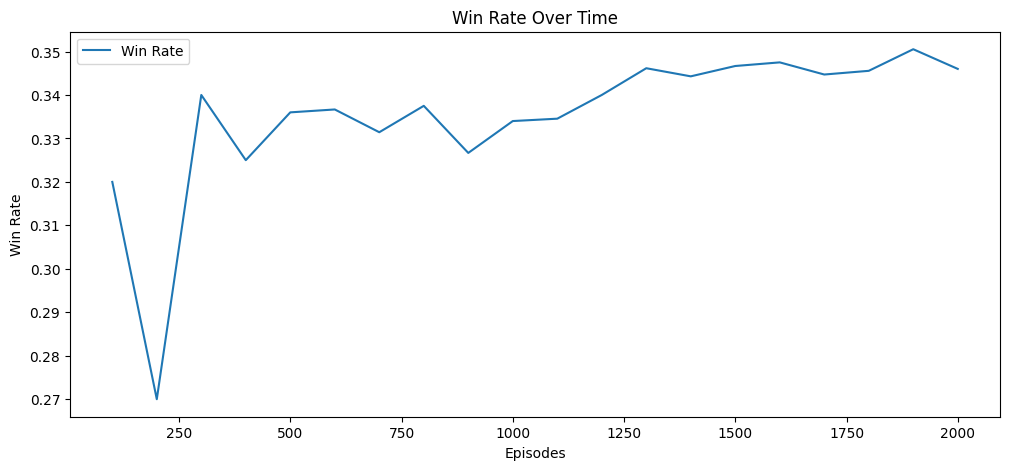

In [12]:
visualize_dqn_results(agent, win_rates)

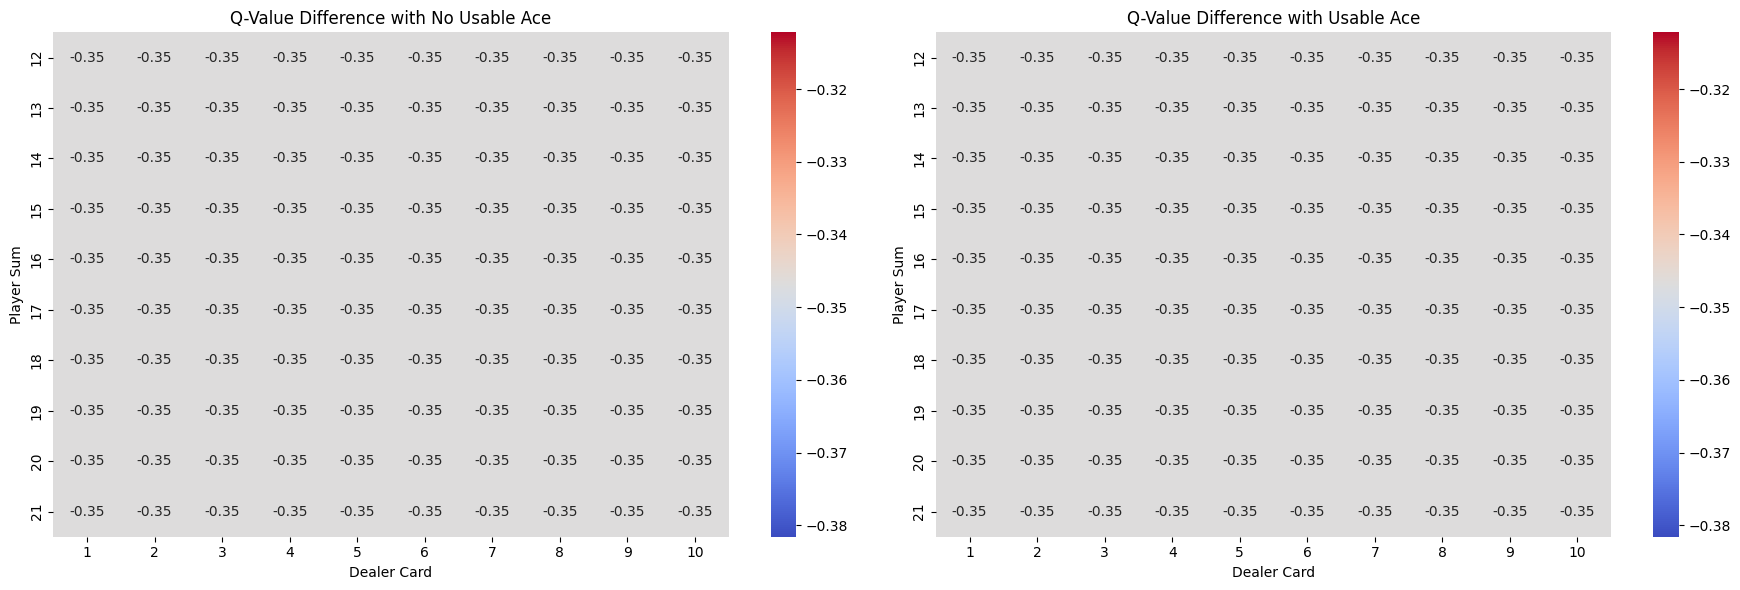

In [15]:
visualize_q_values(agent)

In [ ]:
import re
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML


def update_scene(num, frames, patch): #this box makes a nice little video
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


def show_one_game(agent, seed=333):
    env = gym.make('Blackjack-v1', sab=True, render_mode='rgb_array')
    state, _ = env.reset()

    print("Initial State:", state)

    frames = [env.render()]
    done = False
    didWin = False

    while not done:
        state = np.array(state, dtype=np.float32)
        action = agent.choose_action(state)
        state, reward, done, truncated, _ = env.step(action)
        print(f"State: {state}, Action: {action}, Reward: {reward}")
        frames.append(env.render())
        if done or truncated:
            didWin = reward > 0

    env.close()
    return frames, didWin

frames, didWin = show_one_game(agent)


anim = plot_animation(frames)
HTML(anim.to_jshtml())



Initial State: (21, 6, 1)
State: (21, 6, 1), Action: 0, Reward: 1.0


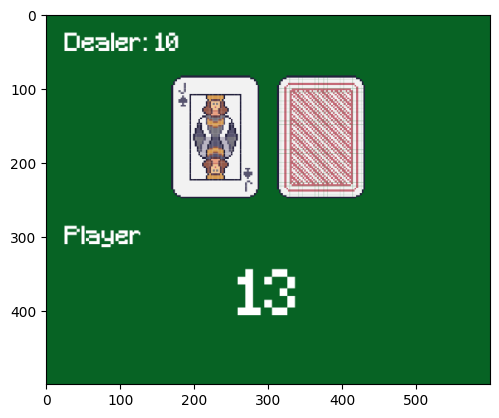

In [19]:
show_one_game(agent)